In [1]:
import numpy as np
import torch
from utils import *
from matplotlib import pyplot as plt
import os
from GPUtil import showUtilization as gpu_usage
from tqdm import tqdm, trange
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used
 
# Define the network structure
H = 300
out = 100
L = 1
class DN(torch.nn.Module):
    def __init__(self):
        super(DN, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, out, bias=True),
            #torch.nn.Dropout(p=0.5),
        )
    def forward(self, input):
        output = self.model(input)
        return output

class another_DN(torch.nn.Module):
    def __init__(self):
        super(another_DN, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, 28, bias=True),
        )
    def forward(self, input):
        output = input
        return output

from kmod.kernel import DifferentiableKernel, KSTKernel, LinearKSTKernel
from utils import Pdist2
#class NeuralKernel(DifferentiableKernel, KSTKernel, LinearKSTKernel): 
# Since we use pytorch rather than autograd.np, we don't follow the above inheritance
class NeuralKernel():
    """
    A neural net + a isotropic Gaussian kernel.
    Parameterization is the same as in the density of the standard normal
    distribution. sigma2 is analogous to the variance.
    """
    def __init__(self, model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, eps, cst):
        self.model = model
        self.another_model = another_model
        self.epsilonOPT = epsilonOPT
        self.sigmaOPT = sigmaOPT
        self.sigma0OPT = sigma0OPT
        self.eps = eps
        self.cst = cst
        self.params = list(model.parameters())+list(another_model.parameters())+[epsilonOPT]+[sigmaOPT]+[sigma0OPT]+[eps]+[cst]

    def compute_feature_matrix(self, XY, V): # compute fea_pq = psi_p(V)-psi_q(V) = n x J,
        """
        Evaluate the Gaussian kernel on the two 2d numpy arrays.

        Parameters
        ----------
        XY : (n1+n2) x d numpy array
        V : J x d numpy array

        Return
        ------
        fea_pq : n x J numpy array
        """
        len_X = XY.shape[0]/2
        J = V.shape[0]

        cst = self.cst
        sigma0 = self.sigma0OPT ** 2
        sigma = self.sigmaOPT ** 2
        epsilon = torch.exp(self.epsilonOPT)/(1+torch.exp(self.epsilonOPT))


        model_XY = self.model(XY)
        another_model_XY = self.another_model(XY)
        model_X = model_XY[0:len_X, :]
        model_Y = model_XY[len_X:, :]
        another_model_X = another_model_XY[0:len_X, :]
        another_model_Y = another_model_XY[len_X:, :]

        model_V = self.model(V)
        another_model_V = self.another_model(V)

        Dxv = Pdist2(model_X, model_V)
        Dyv = Pdist2(model_Y, model_V)
        Dxv_org = Pdist2(another_model_X, another_model_V)
        Dyv_org = Pdist2(another_model_Y, another_model_V)

        Kxv = cst*((1-epsilon) * torch.exp(-(Dxv / sigma0) - (Dxv_org / sigma))**L + epsilon * torch.exp(-Dxv_org / sigma))
        Kyv = cst*((1-epsilon) * torch.exp(-(Dyv / sigma0) - (Dyv_org / sigma))**L + epsilon * torch.exp(-Dyv_org / sigma))

        fea_pq = 1/np.sqrt(J) * (Kxv - Kyv)
        return fea_pq
        
    def compute_UME_mean_variance(self, XY, V): # compute mean and var of UME(X,Y)
        """
        Return the mean and variance of the reduced
        test statistic = \sqrt{n} UME(P, Q)^2
        The estimator of the mean is unbiased (can be negative).

        returns: (mean, variance)
        """
        # get the feature matrices psi (correlated)
        # fea_pq = psi_p(V)-psi_q(V) = n x J,
        J = V.shape[0]
        n = XY.shape[0]/2
        fea_pq = self.compute_feature_matrix(XY, V) # n x J

        # compute the mean 
        t1 = torch.sum( torch.mean(fea_pq, axis=0)**2) * (n/float(n-1))
        t2 = torch.mean(torch.sum(fea_pq**2, axis=1)) / float(n-1)
        UME_mean = t1 - t2

        # compute the variance
        mu = torch.mean(fea_pq, axis=0) # length-J vector
        UME_variance = 4.0*torch.mean(np.dot(fea_pq, mu)**2) - 4.0*torch.sum(mu**2)**2

        return UME_mean, UME_variance

# define the loss function
def power_criterion_mix(XY, V, kernel): #  objective to maximize, 
    """
    Note: compared to Jit18, here R is linear mixture of P and Q, we don't need R for the objective
    """
    # compute the mean and variance of the test statistic
    TEMP = kernel.compute_UME_mean_variance(XY, V)
    # calculate objective
    UME_mean = TEMP[0]
    UME_var = TEMP[1]
    UME_std = torch.sqrt(UME_var+10**(-8))
    ratio = torch.div(UME_mean,UME_std)
    return ratio

# save ckeckpoint
def save_model(V, kernel, epoch, folder_path):
    path = folder_path+str(epoch)+'/'
    try:
        os.makedirs(path) 
    except:
        pass
    torch.save(kernel.model.state_dict(), path+'model.pt')
    torch.save(kernel.another_model.state_dict(), path+'another_model.pt')
    torch.save(kernel.epsilonOPT, path+'epsilonOPT.pt')
    torch.save(kernel.sigmaOPT, path+'sigmaOPT.pt')
    torch.save(kernel.sigma0OPT, path+'sigma0OPT.pt')
    torch.save(kernel.cst, path+'cst.pt')
    torch.save(V, path+'V.pt')

# load checkpoint
def load_model(folder_path, epoch=0):
    print('loading model from epoch', epoch)
    path = folder_path+str(epoch)+'/'
    model = DN().cuda()
    model.load_state_dict(torch.load(path+'model.pt'))
    another_model = another_DN().cuda()
    another_model.load_state_dict(torch.load(path+'another_model.pt'))
    epsilonOPT = torch.load(path+'epsilonOPT.pt')
    sigmaOPT = torch.load(path+'sigmaOPT.pt')
    sigma0OPT = torch.load(path+'sigma0OPT.pt')
    eps = torch.load(path+'eps.pt')
    cst = torch.load(path+'cst.pt')
    V = torch.load(path+'V.pt')
    kernel = NeuralKernel(model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, eps, cst)
    return V, kernel



/math/home/eruisun/software/anaconda/envs/LFI/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import Packages

In [2]:
from kmod import density, util, kernel
from kmod import mctest as mct
import matplotlib.pyplot as plt
import autograd.numpy as np
import autograd
import scipy
import kgof
from kmod.mctest import SC_UME as SC_UME


# Load Dataset

In [3]:
# dataset = np.load('~/LFI/Higgs/HIGGS.npy')
%cd ~
dataset = np.load('./LFI/Higgs/HIGGS.npy')
print('background : signal =',np.sum(dataset[:,0]),':',dataset.shape[0]-np.sum(dataset[:,0]))
print('signal :',np.sum(dataset[:,0])/dataset.shape[0]*100,'%')
# split into signal and background
dataset_P = dataset[dataset[:,0]==0][:, 1:] # background (5170877, 28)
dataset_Q = dataset[dataset[:,0]==1][:, 1:] # signal     (5829122, 28) 

/math/home/eruisun
background : signal = 5829122.0 : 5170877.0
signal : 52.99202299927481 %


In [4]:
# random select train X,Y
datptr = kgof.data.Data(dataset_P[np.random.choice(dataset_P.shape[0], 100_000)])
datqtr = kgof.data.Data(dataset_Q[np.random.choice(dataset_Q.shape[0], 100_000)])
# random select train Z
background_events = dataset_P[np.random.choice(dataset_P.shape[0], 90_000)]
signal_events = dataset_Q[np.random.choice(dataset_Q.shape[0], 10_000)]
datrtr = kgof.data.Data(np.concatenate((signal_events, background_events), axis=0))

# Optimize

注意这里PQR三个都被split了

In [5]:
# split the data into training/test sets
Xtr, Ytr, Ztr = [D.data() for D in [datptr, datqtr, datrtr]]

## Train the kernel and $W$

In [ ]:
def early_stopping(validation_losses, epoch):
    i = np.argmin(validation_losses)
    # print(i)
    if epoch - i > 10:
        return True
    else:
        return False

In [6]:

def optimize_3sample_criterion_and_kernel(prepared_batched_XY, # total_S, is a list
                                          validation_XY, # validation set, is 2n*d
                                        V, kernel, # params
                                        N_epoch=100, learning_rate=0.01, momentum=0.9, # optimizer
                                        print_every=10, # print and save checkpoint
                                        early_stopping=None, # early stopping boolean function
                                        fig_loss_epoch_name='', # name of the loss vs epoch figure
                                        ):
    params = list(kernel.params) + [V]
    optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=momentum)
    total_S = prepared_batched_XY
    batches = len(total_S)
    #############################
    # start training
    #############################
    validation_ratio_list = np.ones([N_epoch])*np.inf
    for t in range(N_epoch):
        print('epoch',t)
        order = np.random.permutation(batches)
        for ind in tqdm(order):
            optimizer.zero_grad()
            # calculate parameters
            XY = total_S[ind]
            # calculate MMD
            ratio = power_criterion_mix(XY, V, kernel)
            obj = -ratio
            # update parameters
            obj.backward(retain_graph=False)
            obj.step()     
        #validation
        with torch.torch.no_grad():
            validation_ratio = power_criterion_mix(validation_XY, V, kernel).item()
            validation_ratio_list.append(validation_ratio)
            print('validation =', validation_ratio_list[t])
        # print log
        if t%print_every==0:
            plt.plot(validation_ratio_list[:t])
            plt.savefig(fig_loss_epoch_name)
            plt.clf()
            save_model(params)
        # early stopping
        if early_stopping(validation_ratio_list, t):
            save_model(params)
            plt.plot(validation_ratio_list[:t])
            plt.savefig(fig_loss_epoch_name)
            plt.clf()
            return V, kernel
    return V, kernel

In [ ]:
# train the network
def train(n_tr, J=10, # size of X_tr, Y_tr and W=V
        load_epoch=0, # load checkpoint if >0
        batch_size=32, N_epoch=100, learning_rate=0.01, momentum=0.9, # optimizer
        print_every=10, # print and save checkpoint
        early_stopping=None, # early stopping boolean function
        fig_loss_epoch_name='', # name of the loss vs epoch figure
        seed = 0, # random seed
        ):
    n_backup = n_tr
    try:
        os.mkdir('./checkpoint n_tr=%d'%n_backup)
    except:
        pass
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    dtype = torch.float
    device = torch.device("cuda:0")

    batches = n_tr//batch_size + 1 
    n = batches*batch_size  
    X = dataset_P[0:n]
    Y = dataset_Q[0:n]

    # prepare training data
    total_S = [(X[i*batch_size:(i+1)*batch_size], 
                Y[i*batch_size:(i+1)*batch_size]) 
                for i in range(batches)]
    total_S = [MatConvert(np.concatenate((X, Y), axis=0), device, dtype) for (X, Y) in total_S]

    # prepare NN and kernel and V=W 
    model = DN().cuda()
    another_model = another_DN().cuda()

    epsilonOPT = MatConvert(np.zeros(1), device, dtype) # set to 0 for MMD-G
    epsilonOPT.requires_grad = True
    sigmaOPT = MatConvert(np.sqrt(np.random.rand(1) * 0.3), device, dtype)
    sigmaOPT.requires_grad = True
    sigma0OPT = MatConvert(np.sqrt(np.random.rand(1) * 0.002), device, dtype)
    sigma0OPT.requires_grad = True
    eps=MatConvert(np.zeros((1,)), device, dtype)
    eps.requires_grad = True
    cst=MatConvert(1*np.ones((1,)), device, dtype)
    cst.requires_grad = True
    kernel = NeuralKernel(model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, eps, cst)

    V = MatConvert(np.random.randn(J, 28), device, dtype)

    # load checkpoint if one want to start from a previous checkpoint
    if load_epoch>0:
        V, kernel = load_model(n_backup, load_epoch)
        print('loaded')
    kernel.model.eval()
    kernel.another_model.eval()

    # validation data
    validation_XY = np.concatenate((dataset_P[n + np.random.choice(n, 10000, replace=False)], 
                            dataset_Q[n + np.random.choice(n, 10000, replace=False)]), axis=0)
    validation_XY = MatConvert(validation_XY, device, dtype)

    #############################
    # start training
    #############################
    return optimize_3sample_criterion_and_kernel(total_S, # total_S, is a list
                                          validation_XY, # validation set, is 2n*d
                                        V, kernel, # params
                                        N_epoch=100, learning_rate=0.01, momentum=0.9, # optimizer
                                        print_every=10, # print and save checkpoint
                                        early_stopping=None, # early stopping boolean function
                                        fig_loss_epoch_name='', # name of the loss vs epoch figure
                                        )


## Test
求几sigma不需要thres $T_\alpha$
求p-value就行


再注意它们的p-value是用asym估计的，
我们也是用Gaussian估计？
一样？

In [9]:
def test_one_time(arg):
    # random select test X,Y
    datpte = kgof.data.Data(dataset_P[np.random.choice(dataset_P.shape[0], 10_000)])
    datqte = kgof.data.Data(dataset_Q[np.random.choice(dataset_Q.shape[0], 10_000)])
    # random select test Z
    # background_events = dataset_P[np.random.choice(dataset_P.shape[0], 1000)]
    # signal_events = dataset_Q[np.random.choice(dataset_Q.shape[0], 100)]
    if arg == 'null':
        datrte =  kgof.data.Data(dataset_P[np.random.choice(dataset_P.shape[0], 10_000)])
    elif arg == 'mix':
        background_events = dataset_P[np.random.choice(dataset_P.shape[0], 100)]
        signal_events = dataset_Q[np.random.choice(dataset_Q.shape[0], 9900)]
        datrte = kgof.data.Data(np.concatenate((signal_events, background_events), axis=0))

    # Gaussian kernel constructed with the optimized squared bandwidth
    k_opt = kernel.KGauss(gw2_opt)
    # Construct an object to represent the test. Use the test data here (not the training data!)
    scume_opt3 = mct.SC_UME(datpte, datqte, k_opt, k_opt, V_opt, V_opt)
    # returns a dictionary
    test_result = scume_opt3.perform_test(datrte)
    # display(test_result)
    return test_result

In [10]:
from tqdm import tqdm, trange
Monte = 100
null_test_results = []
test_results = []
for i in trange(Monte):
    test_results.append(test_one_time('mix'))
    null_test_results.append(test_one_time('null'))

100%|██████████| 1000/1000 [00:36<00:00, 27.27it/s]


In [11]:
pvalues = np.array([r['pvalue'] for r in test_results])
null_pvalues = np.array([r['pvalue'] for r in null_test_results])
# transform into sigma unit
from scipy.stats import norm
pvalues = norm.ppf(1-pvalues)
null_pvalues = norm.ppf(1-null_pvalues)
# print mean
print('mean of mix pvalues: ', np.mean(pvalues))
print('mean of null pvalues: ', np.mean(null_pvalues))

mean of mix pvalues:  0.16720177721431645
mean of null pvalues:  -0.1452878041857865


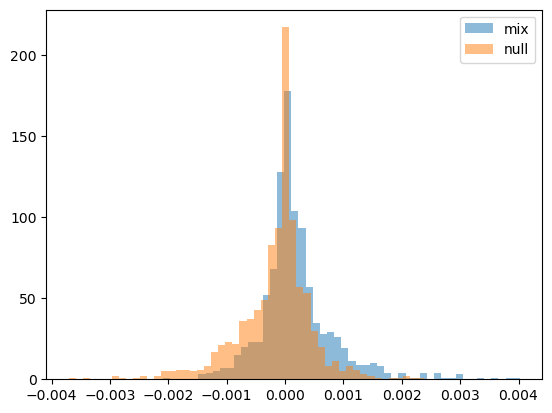

In [12]:
plt.hist([r['test_stat'] for r in test_results], bins=50, alpha=0.5, label='mix')
plt.hist([r['test_stat'] for r in null_test_results], bins=50, alpha=0.5, label='null')
plt.legend()

# 用模拟值算pval

In [13]:
simulated_pvalues = []
null_stats = [r['test_stat'] for r in null_test_results]
for i in trange(Monte):
    stat = test_results[i]['test_stat']
    simulated_pvalues.append(np.mean(stat > np.array(null_stats)))

100%|██████████| 1000/1000 [00:03<00:00, 269.92it/s]


In [14]:
# simulated_pvalues = norm.ppf(1-np.array(simulated_pvalues))
simulated_pvalue = np.mean(simulated_pvalues)
print('mean of simulated pvalues: ', np.mean(simulated_pvalues))
# into sigma unit
simulated_pvalue = norm.ppf(simulated_pvalue)
print('simulated pvalue in sigma: ', simulated_pvalue)

mean of simulated pvalues:  0.64281
simulated pvalue in sigma:  0.36597999934450454


In [ ]:

# if __name__ == "__main__":
#     dataset = np.load('../HIGGS.npy')
#     dataset_P = dataset[dataset[:,0]==0][:, 1:] # background (5829122, 28)
#     dataset_Q = dataset[dataset[:,0]==1][:, 1:] # signal     (5170877, 28)

#     n_list = [1300000, 1000000, 700000, 400000, 200000, 50000]
#     for n in [1300000, 1000000, 700000, 400000, 200000, 50000]:
#         for i in range(11):
#             n_list.append(n+i)
    
#     for n in n_list:
#         print('------ n =', n, '------')
#         model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = train(n, 
#             N_epoch = 501,
#             print_every = 5, 
#             batch_size = 1024, 
#             learning_rate = 2e-3, 
#             SGD = True, 
#             dataset_P = dataset_P, dataset_Q = dataset_Q,
#             momentum=0.99, weight_decay=0.000)
